# Detector de edad de una persona (Spanish version)

## Por Luis Miguel García Marín

## Importando librerías

Importamos las librerías necesarias para el desarrollo de nuestra red neuronal.

In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Cargando el dataset

Cargamos nuestro dataset de 27305 imágenes faciales de 48x48 píxeles con sus etiquetas, en nuestro caso en formato .csv. 
El dataset puede descargarse en: https://www.kaggle.com/nipunarora8/age-gender-and-ethnicity-face-data-csv

In [2]:
df = pd.read_csv("data/age_gender.csv")

## Explorando los datos I

Observamos las 5 primeras filas (imagen con etiquetas) del dataset.

In [3]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


## Convirtiendo los píxeles de los datos en un array numpy

Al explorar los datos, vemos que los píxeles están expresados como string separados por espacios. Para manejar estos datos mejor, vamos a convertirlos en un array de números, ayudándonos de una función lambda, que utiliza las funciones x.split() (para separar los elementos por cada espacio) y np.array() (para construir el array, con formato numérico float de precisión 32).

In [4]:
df['pixels'] = df['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

## Explorando los datos II

Vemos que ahora los píxeles sí son un array numérico.

In [5]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


## Visualizando los datos

Previsualizamos ahora unas 20 imagenes del dataset, acompañadas de todas las etiquetas. Aunque nosotros haremos uso sólo de la etiqueta 'age'.

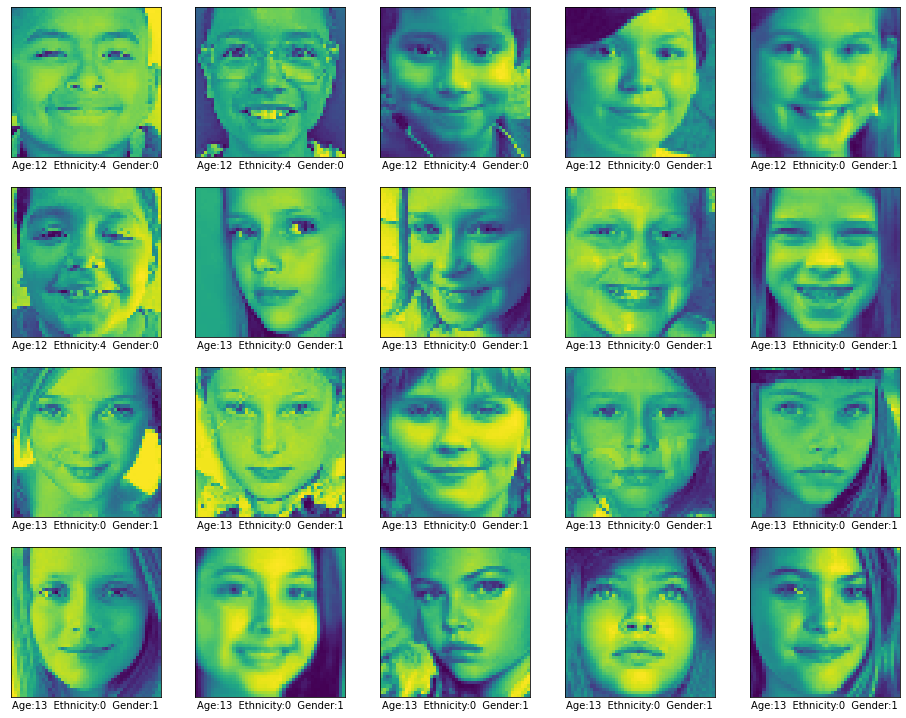

In [6]:
plt.figure(figsize = (16,16))
for i in range(1500,1520):
    plt.subplot(5, 5, (i%25)+1) # Para mostrarlos en cuadricula
    plt.xticks([]) # Para dejar un poco de margen
    plt.yticks([]) # Para dejar un poco de margen
    plt.grid(False)
    plt.imshow(df['pixels'].iloc[i].reshape(48,48)) # Convertimos la imagen de 1D a 2D
    plt.xlabel( # Añadimos las etiquetas
        "Age:" + str(df['age'].iloc[i]) +
        "  Ethnicity:" + str(df['ethnicity'].iloc[i]) +
        "  Gender:" + str(df['gender'].iloc[i])
    )

plt.show()

## Extrayendo las imágenes

Obtenemos los píxeles en x, convirtiendolos en una tupla para poder acceder correctamente al atributo .shape

In [7]:
x = np.array(df['pixels'].tolist())

x.shape

(23705, 2304)

## Normalizando las imágenes

Normalizamos los píxeles para que el modelo pueda trabajar mejor con valores flotantes entre 0 y 1. Sabiendo que el máximo valor de un píxel es de 255.

In [8]:
x = x / 255

## Convirtiendo los píxeles de 1D a 3D

Para tener información de los píxeles cercanos y poder realizar convolución, realizamos ahora un reshape a los píxeles para pasar de trabajar con una dimensión a tres dimensiones (ancho en píxeles, alto en píxeles y número de canales de color). De esta forma, la entrada de nuestra red neuronal también tendrá estas dimensiones.

In [9]:
x = x.reshape(-1,48,48,1)

In [10]:
x.shape

(23705, 48, 48, 1)

## Extrayendo las etiquetas

Obtenemos en y las etiquetas de las edades. Ya que no hay un número de clases total predefinido (la máxima edad de una persona no tiene un límite estricto), no nos conviene categorizar.

In [11]:
y = df['age']

## Separar los datos en train y test

Haciendo uso de la función train_test_split, particionamos ahora el dataset completo en train y test.

In [12]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.22, random_state = 37
)

## Construyendo el modelo

Construimos el modelo de la red neuronal, en este caso es una modificación de la del cuadernillo 3 (Convolutional Neural Networks). La entrada debe ser de 3 dimensiones como especificamos anteriormente (48,48,1). Sin embargo, la salida buscamos que sea un número real que nos indique la edad predicha de la persona de la foto, por lo que la salida será una sola unidad con activación relu, ya que no tenemos como otras veces un número específico de categorías entre las que repartir los porcentajes solución.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential(L.InputLayer(input_shape=(48,48,1)))
model.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="relu", input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"))
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"))
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation="relu"))

## Compendiendo (Summarizing) el modelo

Sumarizamos el modelo.

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0

## Compilando el modelo

En la compilación del modelo indicamos utilizar 'adam' (método del descenso del gradiente estocástico) como optimizador, el error cuadrático medio como función de pérdida y el error absoluto medio como métricas.

In [15]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

## Entrenando el modelo

Procedemos a realizar el entrenamiento del modelo, de unas 20 épocas.

In [16]:
model.fit(
    x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=64
)

Epoch 1/20
289/289 [==============================] - 3s 11ms/step - loss: 332.3342 - mae: 13.8695 - val_loss: 1088.2957 - val_mae: 27.6129
Epoch 2/20
289/289 [==============================] - 2s 8ms/step - loss: 202.7516 - mae: 10.6614 - val_loss: 587.2354 - val_mae: 19.2056
Epoch 3/20
289/289 [==============================] - 2s 7ms/step - loss: 168.1027 - mae: 9.6140 - val_loss: 122.9288 - val_mae: 8.0803
Epoch 4/20
289/289 [==============================] - 2s 7ms/step - loss: 153.4476 - mae: 9.1409 - val_loss: 173.9724 - val_mae: 9.6985
Epoch 5/20
289/289 [==============================] - 2s 7ms/step - loss: 145.0757 - mae: 8.8778 - val_loss: 102.8419 - val_mae: 7.6934
Epoch 6/20
289/289 [==============================] - 2s 7ms/step - loss: 139.2640 - mae: 8.6717 - val_loss: 94.8595 - val_mae: 7.1141
Epoch 7/20
289/289 [==============================] - 2s 7ms/step - loss: 131.8873 - mae: 8.4012 - val_loss: 114.1211 - val_mae: 8.1974
Epoch 8/20
289/289 [=======================

## Examinando las Predicciones

Creamos la función make_predictions para realizar predicciones a parte y poner a prueba nuestro modelo.

In [17]:
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(48, 48), color_mode='grayscale')
    image = image_utils.img_to_array(image)
    
    image = image.reshape(1,48,48,1) # Redimensionamos la imagen
    image = image / 255 # Normalizamos la imagen
    preds = model.predict(image)
    return preds

## Funcion detectora de edad

Creamos finalmente la función detector_de_edad, que hace uso de la función make_predictions y nos presenta el resultado de una forma más legíble. 

In [18]:
import math

def detector_de_edad(image_path):
    pred = make_predictions(image_path)
    print("Su edad es: ", math.floor(pred), " años")

Su edad es:  12  años


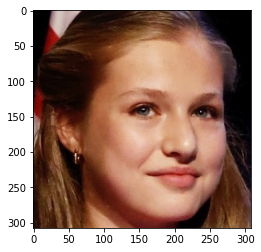

In [19]:
detector_de_edad('data/leonor-15.jpg')

Su edad es:  54  años


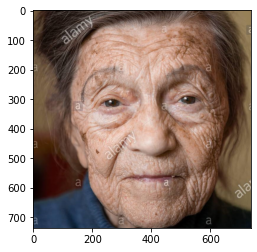

In [20]:
detector_de_edad('data/anciana-90.jpg')

## Clear the Memory

Limpiamos la memoria, en caso de que lo necesitemos.

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)